In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from scipy.stats import mannwhitneyu

In [2]:
results = pd.read_excel("C:\\Users\\vvelezpe\\OneDrive - Imperial College London\\Projects\\VAPOR\\results\\compound_results_filtered_cohort.xlsx")

In [ ]:
metadata = ['File', 'Batch number', 'Sequence position', 'Tube number', 'QC/SAMPLE',
       'Patient ID', 'Sample type', 'Cohort', 'Cohort Type']

dataset = results.drop(columns=metadata)
dataset = np.log1p(dataset)

In [12]:
data_scaled = StandardScaler().fit_transform(dataset)
pca = PCA(n_components=10)
scores = pca.fit_transform(data_scaled)
loadings = pca.components_.T
explained_variance = pca.explained_variance_ratio_

scores_df = pd.DataFrame(scores, columns=[f'PC{i+1}' for i in range(scores.shape[1])])
loadings_df = pd.DataFrame(loadings, index=dataset.columns, columns=[f'PC{i+1}' for i in range(loadings.shape[1])])


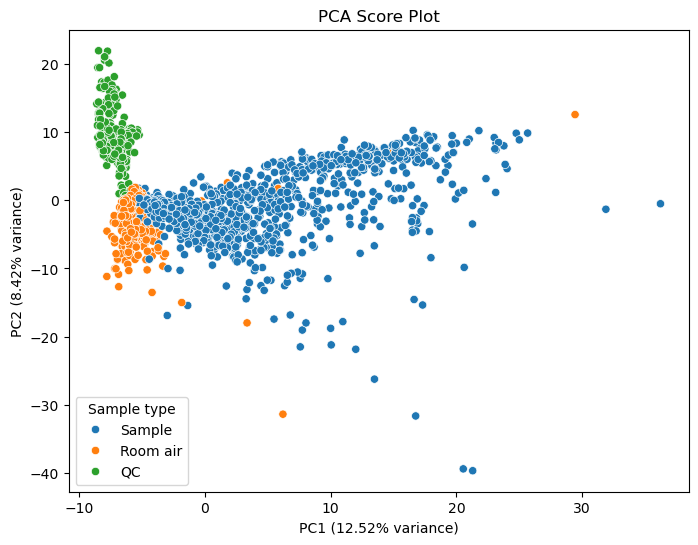

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=scores_df['PC1'], y=scores_df['PC2'], hue=results['Sample type'])
plt.xlabel(f"PC1 ({explained_variance[0]*100:.2f}% variance)")
plt.ylabel(f"PC2 ({explained_variance[1]*100:.2f}% variance)")
plt.title("PCA Score Plot")
plt.show()

In [50]:
pano = pd.read_csv("C:\\Users\\vvelezpe\\OneDrive - Imperial College London\\Projects\\PANORAMA\\PANORAMA Data Summary Breath Only log.csv")

In [51]:
rel = pd.read_excel("C:\\Users\\vvelezpe\\OneDrive - Imperial College London\\Projects\\PANORAMA\\PANORAMA - Related Participants.xlsx")

In [52]:
rel.dropna(inplace=True, how='all')
rel['PANORAMA (PANO) No.'] = rel['PANORAMA (PANO) No.'].str.strip()

In [53]:
pano['PANORAMA (PANO) No.'] = pano['F'].str.split('_').str[0]
pano['PANORAMA (PANO) No.'] = pano['PANORAMA (PANO) No.'].apply(lambda x: x.replace("-", "_"))

In [54]:
pano = pano[pano['PANORAMA (PANO) No.'].isin(rel['PANORAMA (PANO) No.'])]

In [56]:
pano = pano[pano['Group'] != 'DN']
group1 = 'HV'
group2 = 'PD'

In [57]:
numeric_cols = pano.select_dtypes(include='number').columns

# Dictionary to store results
results = []

for col in numeric_cols:
    data1 = pano[pano['Group'] == group1][col]
    data2 = pano[pano['Group'] == group2][col]
    
    stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
        # Determine which group has higher median
    median1 = data1.median()
    median2 = data2.median()
    
    # Determine which group has higher median
    if median1 > median2:
        higher_group = group1
    elif median2 > median1:
        higher_group = group2
    else:
        higher_group = 'Equal'
    
    results.append({
        'Feature': col,
        'U_statistic': stat,
        'p_value': p,
        f'{group1}_median': median1,
        f'{group2}_median': median2,
        'Higher_group': higher_group
    })



# Convert to DataFrame and sort by p-value
results_df = pd.DataFrame(results).sort_values(by='p_value')

# Convert results to DataFrame for better visualization
#results_df = pd.DataFrame(results).T
print(results_df)

                                               Feature  U_statistic   p_value  \
443  563_Cyclopenta[g]-2-benzopyran, 1,3,4,6,7,8-he...        361.0  0.029722   
112                                 141_unknown_7.7268        371.0  0.041117   
114                      143_Disulfide, dimethyl_7.751        374.0  0.045184   
417  525_Cyclopentaneacetic acid, 3-oxo-2-pentyl-, ...        375.0  0.046612   
424                                532_unknown_17.7166        378.5  0.051889   
..                                                 ...          ...       ...   
189                           230_Cyclohexanone_9.5512        526.0  0.994760   
389                             486_Hexadecane_16.0176        528.0  0.994760   
52                                   68_unknown_6.3725        528.0  0.994760   
171                     212_4,4-Dimethyl octane_9.1881        527.0  1.000000   
354                                 446_unknown_14.961        527.0  1.000000   

     HV_median  PD_median H

In [58]:
# Sort results by p-value in ascending order
results_df_sorted = results_df.sort_values(by='p_value')
results_df_sorted.to_csv('C:\\Users\\vvelezpe\\OneDrive - Imperial College London\\Projects\\PANORAMA\\panorama_mannwhitney_hv_pd_related.csv')